In [34]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
import scipy
from matplotlib.lines import Line2D

from cryptic_rnn import *

In [35]:
ops = '+'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
input_vals.sort()
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print(cue_dict)
primitives = generate_primitives(all_syms, cue_dict)
rp = generate_other_reverse_primitives('+', all_syms, cue_dict)
print(primitives)
print(rp)

testseqs = generate_trials(ops, all_syms, all_syms, cue_dict)


{'A': 5, 'B': 11, 'C': 14, 'D': 16}
[['A', '=', 5], ['B', '=', 11], ['C', '=', 14], ['D', '=', 16]]
[['A', ('+', 'C'), '=', 19], ['B', ('+', 'D'), '=', 27]]


In [36]:
# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.005

## running params
epochs = 1200
num_sims = 104

In [51]:
###### functions

def get_reps(model, testdata, hidden_size):
    """extract hidden layer activations for each time step"""
    model.eval()
    trials = []
    hiddens = []
    for testset in testdata:
        for x,y in testset:
            for i in range(len(x)):
                hidden_arr = np.empty((0,  hidden_size))
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                    hidden_arr = np.vstack([hidden_arr, hidden.detach().numpy()])
            hiddens.append(hidden_arr)
            trials.append(str(onehot2seq(x)))

    return hiddens, trials 

def calculate_RDMs(res):
    ## find indices of 100% acc rnns
    acc_df = res['acc_df']
    #all_acc_mods = acc_df.index
    #all_acc_mods = acc_df[(acc_df['acc_train'] == 1) & (acc_df['acc_train_p'] == 1)& (acc_df['acc_train_rp'] == 1)].index
    #all_acc_mods = acc_df[(acc_df['acc_train'] == 1) & (acc_df['acc_train_p'] == 1)].index
    all_acc_mods = acc_df[(acc_df['acc_train_rp'] == 1) & (acc_df['acc_train_p'] == 1)].index

    print('no. 100% trained RNNs: ', len(all_acc_mods))

    mod_list = all_acc_mods # choose only rnns trained to 100%
    # mod_list = np.arange(num_sims)

    # initialise empty lists/arrays
    rdms = [[] for _ in range(4)]
    rdms_rp = [[] for _ in range(4)]
    rdms_p = [[] for _ in range(4)]

    # extracts results from dictionary
    mods = res['mods']
    mods_rp = res['mods_rp']
    mods_p = res['mods_p']
    cue_dicts = res['cue_dicts']
    testseq = generate_trials(ops, all_syms, all_syms, cue_dict)
    ft_cue_dicts = [cue_dicts[j] for j in mod_list]

    for ind, m in enumerate(mod_list): # for each model 
        
        testseqs = change_dict(testseq, cue_dicts[m])
        train_inputs = convert_seq2inputs(testseq, num_classes=num_classes, seq_len=5)
        testset = DataLoader(train_inputs, batch_size=batchsize, shuffle=False)
        
        # get activations for control model
        hiddens, trials = get_reps(mods[m], [testset], hidden_size)
        for h in range(4): 
            hid_vals = np.array([hid[h,:] for hid in hiddens]) # combine activations from each trial for the time step
            rep_mat = euclidean_distances(hid_vals) # calculate euclidean distance matrix between trials
            rdms[h].append(rep_mat)
            
        # get activations for primitive trained model
        hiddens_rp, trials = get_reps(mods_rp[m], [testset], hidden_size)    
        for h in range(4):
            hid_vals = np.array([hid[h,:] for hid in hiddens_rp])
            rep_mat = euclidean_distances(hid_vals)
            rdms_rp[h].append(rep_mat)
        
        # get activations for primitive trained model
        hiddens_p, trials = get_reps(mods_p[m], [testset], hidden_size)    
        for h in range(4):
            hid_vals = np.array([hid[h,:] for hid in hiddens_p])
            rep_mat = euclidean_distances(hid_vals)
            rdms_p[h].append(rep_mat)
            
    return {'rdms': rdms, 'rdms_rp': rdms_rp,'rdms_p': rdms_p, 'ft_cue_dicts': ft_cue_dicts}


# for selecting untrained trials
rank_dict = {'A': -1.5, 'B': -0.5, 'C': 0.5, 'D': 1.5}
rp = generate_other(ops, all_syms, cue_dict) + generate_other_reverse_primitives('+', all_syms, cue_dict)
valset = [t for t in testseqs if t not in rp]
valset_idx = [testseqs.index(val) for val in valset]

def regress_RDM_abs(time_step, rdm, ft_cue_dicts, ranked = False):
    rs = []
    for i, cuedict in enumerate(ft_cue_dicts):
        if ranked:
            curr_tests = change_dict(testseqs, rank_dict)
        else:
            curr_tests = change_dict(testseqs, cuedict)
        truth_outs = [t[-1] for t in curr_tests]
        truth_RDM = abs(np.array([truth_outs]*16) - np.array([truth_outs]*16).T)
        x = []
        y = []
        for p in valset_idx:
            for q in valset_idx:
                x.append(rdm[time_step][i][p,q])
                y.append(truth_RDM[p,q])
        x = np.array(x).reshape(-1,1)
        y = np.array(y)
        model = LinearRegression().fit(x, y)
        r_sq = model.score(x, y)
        rs.append(r_sq)
    return rs

def regress_RDM_abs_init(time_step, rdm, ft_cue_dicts, ranked = False):
    rs = []
    for i, cuedict in enumerate(ft_cue_dicts):
        if ranked:
            curr_tests = change_dict(testseqs, rank_dict)
        else:
            curr_tests = change_dict(testseqs, cuedict)
        init_tests = [[t[0]]+['='] for t in curr_tests ]
        truth_outs = [calculate_output(t, cuedict) for t in init_tests]
        truth_RDM = abs(np.array([truth_outs]*16) - np.array([truth_outs]*16).T)
        x = rdm[time_step][i].reshape(-1,1)
        y = truth_RDM.reshape(16*16)
        model = LinearRegression().fit(x, y)
        r_sq = model.score(x, y)
        rs.append(r_sq)
    return rs


from sklearn.linear_model import LinearRegression

def plot_RDM_regression(dms, dms_p, ft_cue_dicts, ranked = False, title = ''):
    step_rs = []
    step_rs_p = []
    step_num = []
    for s in range(4): 
        rs = regress_RDM_abs(s, dms, ft_cue_dicts, ranked)
        rs_p = regress_RDM_abs(s, dms_p, ft_cue_dicts, ranked)
        step_rs.append(rs)
        step_rs_p.append(rs_p)
        step_num.append([s+1]*len(rs))


    r_sq = [item for sublist in step_rs for item in sublist]
    r_sq_p = [item for sublist in step_rs_p for item in sublist]
    steps = [item for sublist in step_num for item in sublist]

    all_r_sq = r_sq + r_sq_p
    all_steps = steps + steps
    training = ['no primitives']*len(r_sq) + ['with primitives']*len(r_sq_p)

    r_sq_scores = pd.DataFrame({'R_squared': all_r_sq, 'Step': all_steps, 'Training': training})
    x_data = np.append((np.array(steps) - 0.2), (np.array(steps) + 0.2))
    x_jittered = np.array(x_data) + np.random.normal(0,0.05,len(x_data))
    x_jittered = x_jittered - 1
    colors = ['blue']*len(r_sq) + ['orange']*len(r_sq_p)    

    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=5, label='without primitives'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=5, label='with primitives')] 

    fig, ax = plt.subplots(figsize= (8,5))
    violins = sns.violinplot(data=r_sq_scores, x="Step", y="R_squared", hue="Training",\
                             palette = ['white', 'white'])

    for x, y, color in zip(x_jittered, r_sq_scores["R_squared"], colors):
        ax.scatter(x, y, s = 20, color=color, alpha=0.2)

    plt.legend(handles=legend_elements)
    plt.title('Regression between model RDM and ground truth' + title)


# Read data

In [47]:
# read data

save_dir = '../results/representation_analysis/'

with open(save_dir+'res_all', 'rb') as f:
    res1 = pickle.load(f)

# Other

no. 100% trained RNNs:  674


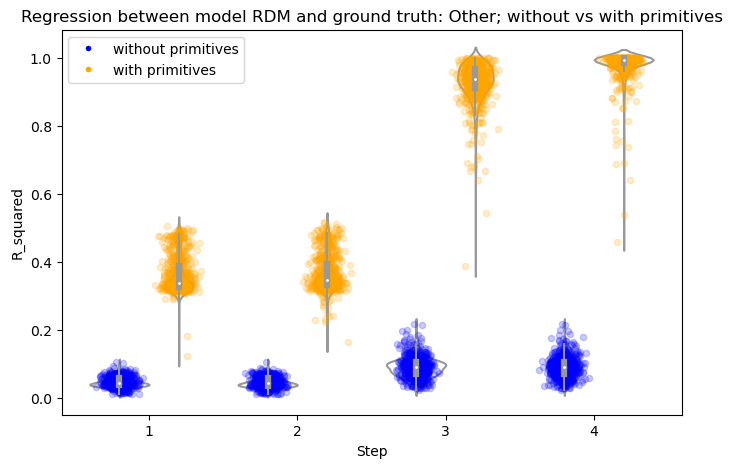

In [50]:
# Other
full_rdmats = calculate_RDMs(res1)
dms = full_rdmats['rdms']
dms_p = full_rdmats['rdms_p']
dms_rp = full_rdmats['rdms_rp']
ft_cue_dicts =  full_rdmats['ft_cue_dicts']

plot_RDM_regression(dms, dms_p, ft_cue_dicts, title = ': Other; without vs with primitives')

no. 100% trained RNNs:  403


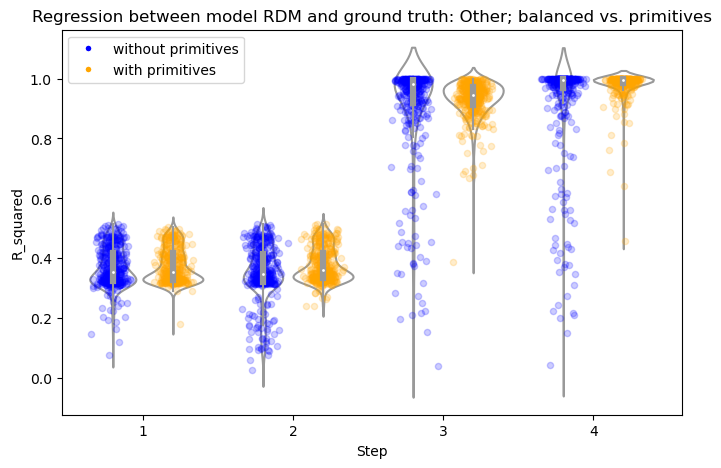

In [53]:
# Other
full_rdmats = calculate_RDMs(res1)
dms = full_rdmats['rdms']
dms_p = full_rdmats['rdms_p']
dms_rp = full_rdmats['rdms_rp']
ft_cue_dicts =  full_rdmats['ft_cue_dicts']

plot_RDM_regression(dms_rp, dms_p, ft_cue_dicts, title = ': Other; balanced vs. primitives')

no. 100% trained RNNs:  800


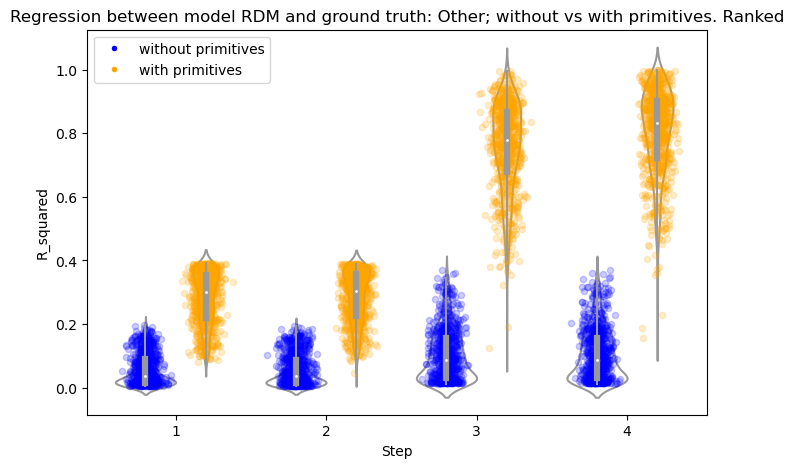

In [44]:
# Other
full_rdmats = calculate_RDMs(res1)
dms = full_rdmats['rdms']
dms_p = full_rdmats['rdms_p']
dms_rp = full_rdmats['rdms_rp']
ft_cue_dicts =  full_rdmats['ft_cue_dicts']

plot_RDM_regression(dms, dms_p, ft_cue_dicts, ranked = True, title = ': Other; without vs with primitives. Ranked')

no. 100% trained RNNs:  800


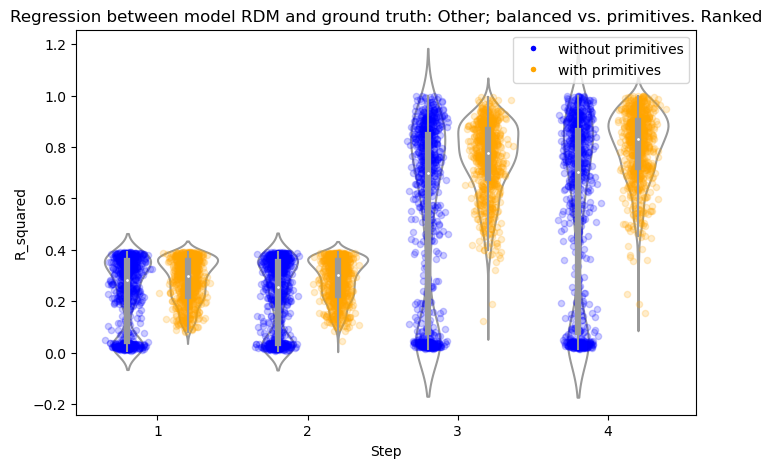

In [45]:
# Other
full_rdmats = calculate_RDMs(res1)
dms = full_rdmats['rdms']
dms_p = full_rdmats['rdms_p']
dms_rp = full_rdmats['rdms_rp']
ft_cue_dicts =  full_rdmats['ft_cue_dicts']

plot_RDM_regression(dms_rp, dms_p, ft_cue_dicts,ranked=True, title = ': Other; balanced vs. primitives. Ranked')

In [28]:
# Full

# Lazy 

In [54]:
# read data

save_dir = '../results/representation_analysis/'

with open(save_dir+'res_all_lazy', 'rb') as f:
    res1 = pickle.load(f)

In [55]:
res1.keys()

dict_keys(['res', 'mods', 'mods_p', 'mods_rp', 'tests', 'cue_dicts', 'acc_df'])

In [62]:
def calculate_RDMs(res):
    ## find indices of 100% acc rnns
    acc_df = res['acc_df']
    #all_acc_mods = acc_df.index
    #all_acc_mods = acc_df[(acc_df['acc_train'] == 1) & (acc_df['acc_train_p'] == 1)& (acc_df['acc_train_rp'] == 1)].index
    #all_acc_mods = acc_df[(acc_df['acc_train'] == 1) & (acc_df['acc_train_p'] == 1)].index
    all_acc_mods = acc_df[(acc_df['acc_train_rp'] == 1) & (acc_df['acc_train_p'] == 1)].index

    print('no. 100% trained RNNs: ', len(all_acc_mods))

    mod_list = all_acc_mods # choose only rnns trained to 100%
    # mod_list = np.arange(num_sims)

    # initialise empty lists/arrays
    rdms = [[] for _ in range(4)]
    rdms_rp = [[] for _ in range(4)]
    rdms_p = [[] for _ in range(4)]

    # extracts results from dictionary
    mods = res['mods']
    mods_rp = res['mods_rp']
    mods_p = res['mods_p']
    cue_dicts = res['cue_dicts']
    testseq = generate_trials(ops, all_syms, all_syms, cue_dict)
    ft_cue_dicts = [cue_dicts[j] for j in mod_list]

    for ind, m in enumerate(mod_list): # for each model 
        
        testseqs = change_dict(testseq, cue_dicts[m])
        train_inputs = convert_seq2inputs(testseq, num_classes=num_classes, seq_len=5)
        testset = DataLoader(train_inputs, batch_size=batchsize, shuffle=False)
        
        # get activations for control model
        hiddens, trials = get_reps(mods[m], [testset], hidden_size)
        for h in range(4): 
            hid_vals = np.array([hid[h,:] for hid in hiddens]) # combine activations from each trial for the time step
            rep_mat = euclidean_distances(hid_vals) # calculate euclidean distance matrix between trials
            rdms[h].append(rep_mat)
            
        # get activations for primitive trained model
        hiddens_rp, trials = get_reps(mods_rp[m], [testset], hidden_size)    
        for h in range(4):
            hid_vals = np.array([hid[h,:] for hid in hiddens_rp])
            rep_mat = euclidean_distances(hid_vals)
            rdms_rp[h].append(rep_mat)
        
        # get activations for primitive trained model
        hiddens_p, trials = get_reps(mods_p[m], [testset], hidden_size)    
        for h in range(4):
            hid_vals = np.array([hid[h,:] for hid in hiddens_p])
            rep_mat = euclidean_distances(hid_vals)
            rdms_p[h].append(rep_mat)
            
    return {'rdms': rdms, 'rdms_rp': rdms_rp,'rdms_p': rdms_p, 'ft_cue_dicts': ft_cue_dicts}


no. 100% trained RNNs:  800


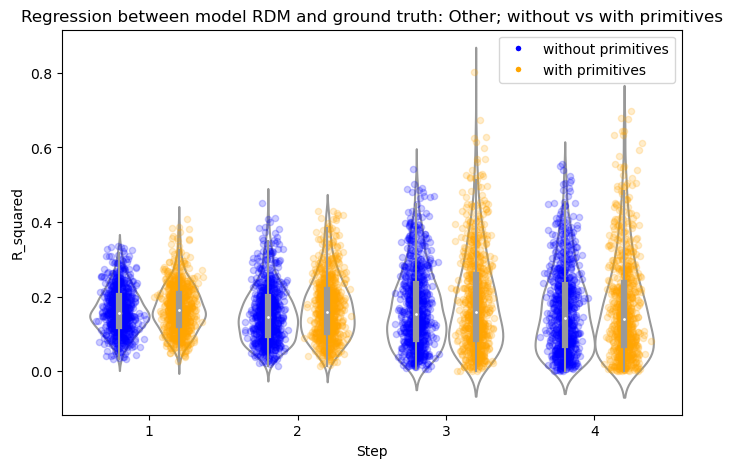

In [58]:
# All 
full_rdmats = calculate_RDMs(res1)
dms = full_rdmats['rdms']
dms_p = full_rdmats['rdms_p']
dms_rp = full_rdmats['rdms_rp']
ft_cue_dicts =  full_rdmats['ft_cue_dicts']

plot_RDM_regression(dms, dms_p, ft_cue_dicts, title = ': Other; without vs with primitives')

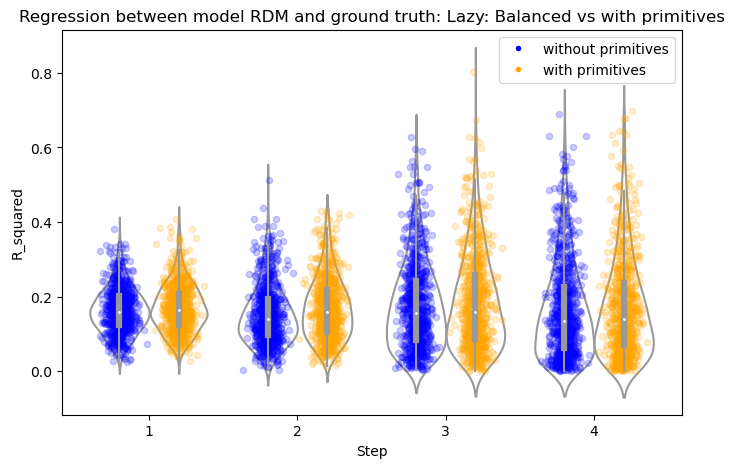

In [59]:
plot_RDM_regression(dms_rp, dms_p, ft_cue_dicts, title = ': Lazy: Balanced vs with primitives')

no. 100% trained RNNs:  735


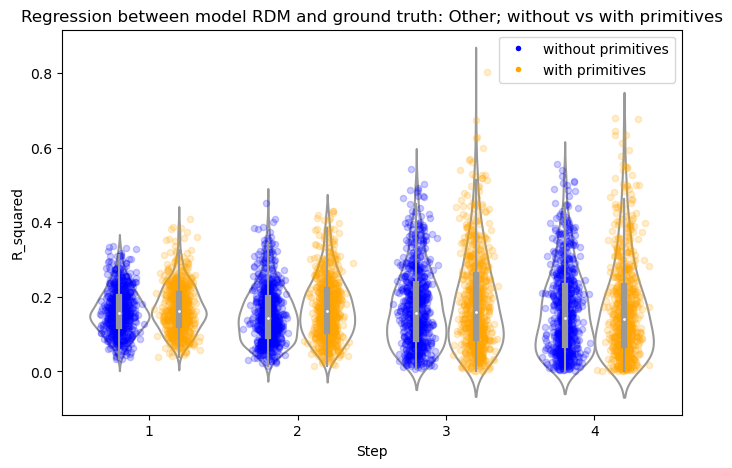

In [61]:
# 100% trained 
full_rdmats = calculate_RDMs(res1)
dms = full_rdmats['rdms']
dms_p = full_rdmats['rdms_p']
dms_rp = full_rdmats['rdms_rp']
ft_cue_dicts =  full_rdmats['ft_cue_dicts']

plot_RDM_regression(dms, dms_p, ft_cue_dicts, title = ': Other; without vs with primitives')

no. 100% trained RNNs:  723


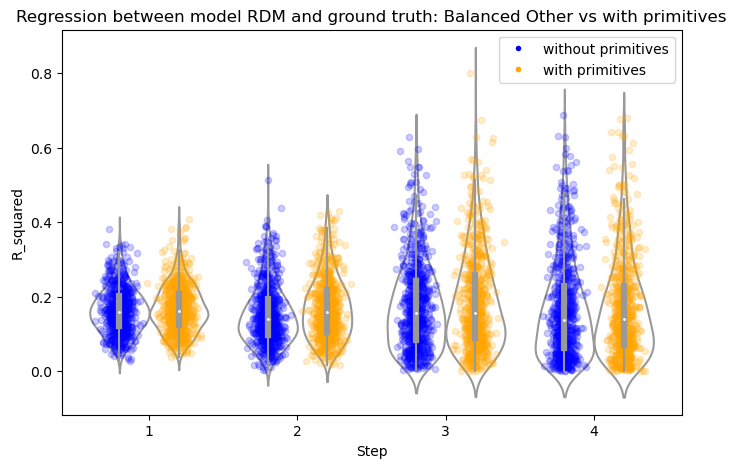

In [63]:
# 100% trained 
full_rdmats = calculate_RDMs(res1)
dms = full_rdmats['rdms']
dms_p = full_rdmats['rdms_p']
dms_rp = full_rdmats['rdms_rp']
ft_cue_dicts =  full_rdmats['ft_cue_dicts']

plot_RDM_regression(dms_rp, dms_p, ft_cue_dicts, title = ': Balanced Other vs with primitives')